# 测试

In [ ]:
!pip list

In [3]:
!pip install transformers

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 174.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 184.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 172.4 kB/s eta 0:00:0000:0100:02


In [25]:
from transformers import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer.tokenize('John\'s from U.S.')

['John', "'", 's', 'from', 'U', '.', 'S', '.']

In [1]:
from datasets import load_dataset

dataset = load_dataset('glue', name='cola')

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
import torch
from d2l import torch as d2l

In [4]:
class ColaDataset(torch.utils.data.Dataset):
    """用于加载cola数据集"""

    def __init__(self, dataset, num_steps, tokenizer, vocab=None):
        self.num_steps = num_steps
        self.tokens = [tokenizer.tokenize(sen) for sen in dataset['sentence']]
        maxlen = max([len(tokens) for tokens in self.tokens])
        print(f'Max length of token sequence: {maxlen}')
        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(self.tokens,
                                   reserved_tokens=['<pad>', '<cls>'])
        else:
            self.vocab = vocab
        out = list(map(self._preprocess, self.tokens))
        all_token_ids = [token_ids for token_ids, _ in out]
        all_valid_lens = [valid_lens for _, valid_lens in out]
        self.all_token_ids = torch.tensor(all_token_ids, dtype=torch.long)
        self.all_valid_lens = torch.tensor(all_valid_lens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, tokens):
        self._truncate_tokens(tokens)
        tokens = ['<cls>'] + tokens
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.num_steps - len(tokens))
        valid_lens = len(tokens)
        return token_ids, valid_lens

    def _truncate_tokens(self, tokens):
        # 为"<cls>标签预留位置"
        while len(tokens) > self.num_steps - 1:
            tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], 
                self.all_valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [5]:
train_set = ColaDataset(dataset['train'], 50, tokenizer)

Max length of token sequence: 45
read 8551 examples


In [6]:
vocab = train_set.vocab
print(f'词表大小: {len(vocab)}') 

词表大小: 5956


In [7]:
vocab = train_set.vocab
print(f'词表大小: {len(vocab)}')  # 不区分大小写，词表大小为1881；区分大小写为2003
test_set = ColaDataset(dataset['test'], 50, tokenizer, vocab)
valid_set = ColaDataset(dataset['validation'], 50, tokenizer, vocab)

Max length of token sequence: 36
read 1063 examples
Max length of token sequence: 34
read 1043 examples


In [23]:
vocab['film']

3518

In [8]:
test_set[0]  # ((tokens, valid_lens), label) 

((tensor([   2,   25, 2426,  131, 1347,    4,  213,    3,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1]),
  tensor(8)),
 tensor(-1))

In [85]:
dataset['test'][0]

{'sentence': 'Bill whistled past the house.', 'label': -1, 'idx': 0}

In [87]:
tokenizer.tokenize(dataset['test']['sentence'][0])

['Bill', 'whistle', '##d', 'past', 'the', 'house', '.']

In [16]:
vocab.idx_to_token[:20]

['<unk>',
 '<pad>',
 '<cls>',
 '.',
 'the',
 'to',
 'I',
 'The',
 'a',
 'that',
 'is',
 'John',
 ',',
 "'",
 'of',
 'and',
 'was',
 'in',
 '?',
 'you']

In [31]:
batch_size = 32
train_iter = torch.utils.data.DataLoader(train_set, batch_size)
test_iter = torch.utils.data.DataLoader(test_set, batch_size)
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size)
print(f'训练集长度: {len(train_iter)}, 测试集长度: {len(test_iter)}, '
      f'验证集长度: {len(valid_iter)}')

for (X, valid_len), y in train_iter:
    print(f'X: {X.shape}, 有效长度: {valid_len.shape}, y: {y.shape}')
    break

训练集长度: 268, 测试集长度: 34, 验证集长度: 33
X: torch.Size([32, 50]), 有效长度: torch.Size([32]), y: torch.Size([32])


In [20]:
len(train_set.tokens)

8551

In [32]:
train_set.tokens[100]

['If',
 'you',
 'eat',
 'more',
 ',',
 'you',
 'want',
 'corresponding',
 '##ly',
 'less',
 '.']

In [22]:
dataset['train'][100]

{'sentence': 'If you eat more, you want correspondingly less.',
 'label': 1,
 'idx': 100}

# 训练词向量

In [18]:
from gensim.models import word2vec

file_path = 'autodl-tmp/'
model = word2vec.Word2Vec(sentences=train_set.tokens, vector_size=512, sg=1, min_count=1)

In [20]:
print(f'词向量模型中保存的单词数量为 {len(model.wv.index_to_key)}')
model.save(file_path + "cola_word_vec_sg_min1.bin")

词向量模型中保存的单词数量为 5953


In [22]:
model.wv.key_to_index['film']

3670

# 因子分析

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [25]:
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
embedding.shape

(5953, 512)

In [42]:
# min_count = 5时的因子分析
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好
KMO值为:  0.9947172771076265


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [43]:
# fa = FactorAnalyzer(25, rotation='varimax')
print('******因子分析******')
fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

******因子分析******


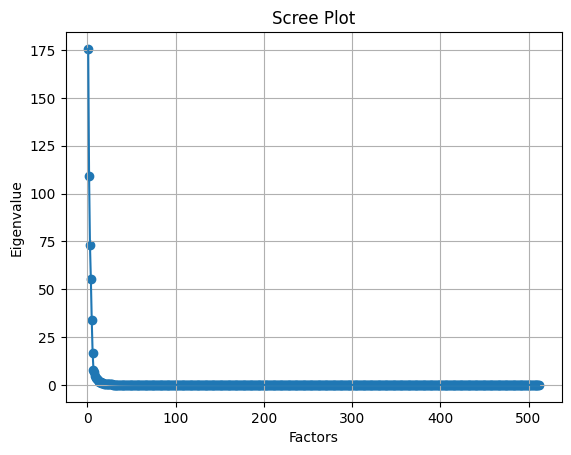

In [44]:
# 可视化, plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

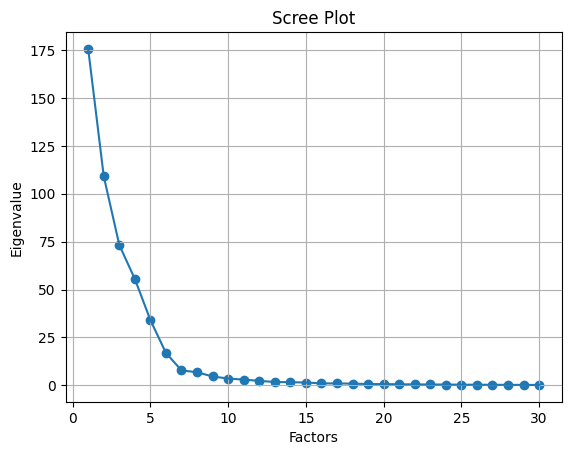

In [45]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [46]:
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)

# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "colaFA.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

(512, 8)


/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if (await self.run_code(code, result,  async_=asy)):


Text(120.72222222222221, 0.5, 'Dimension')

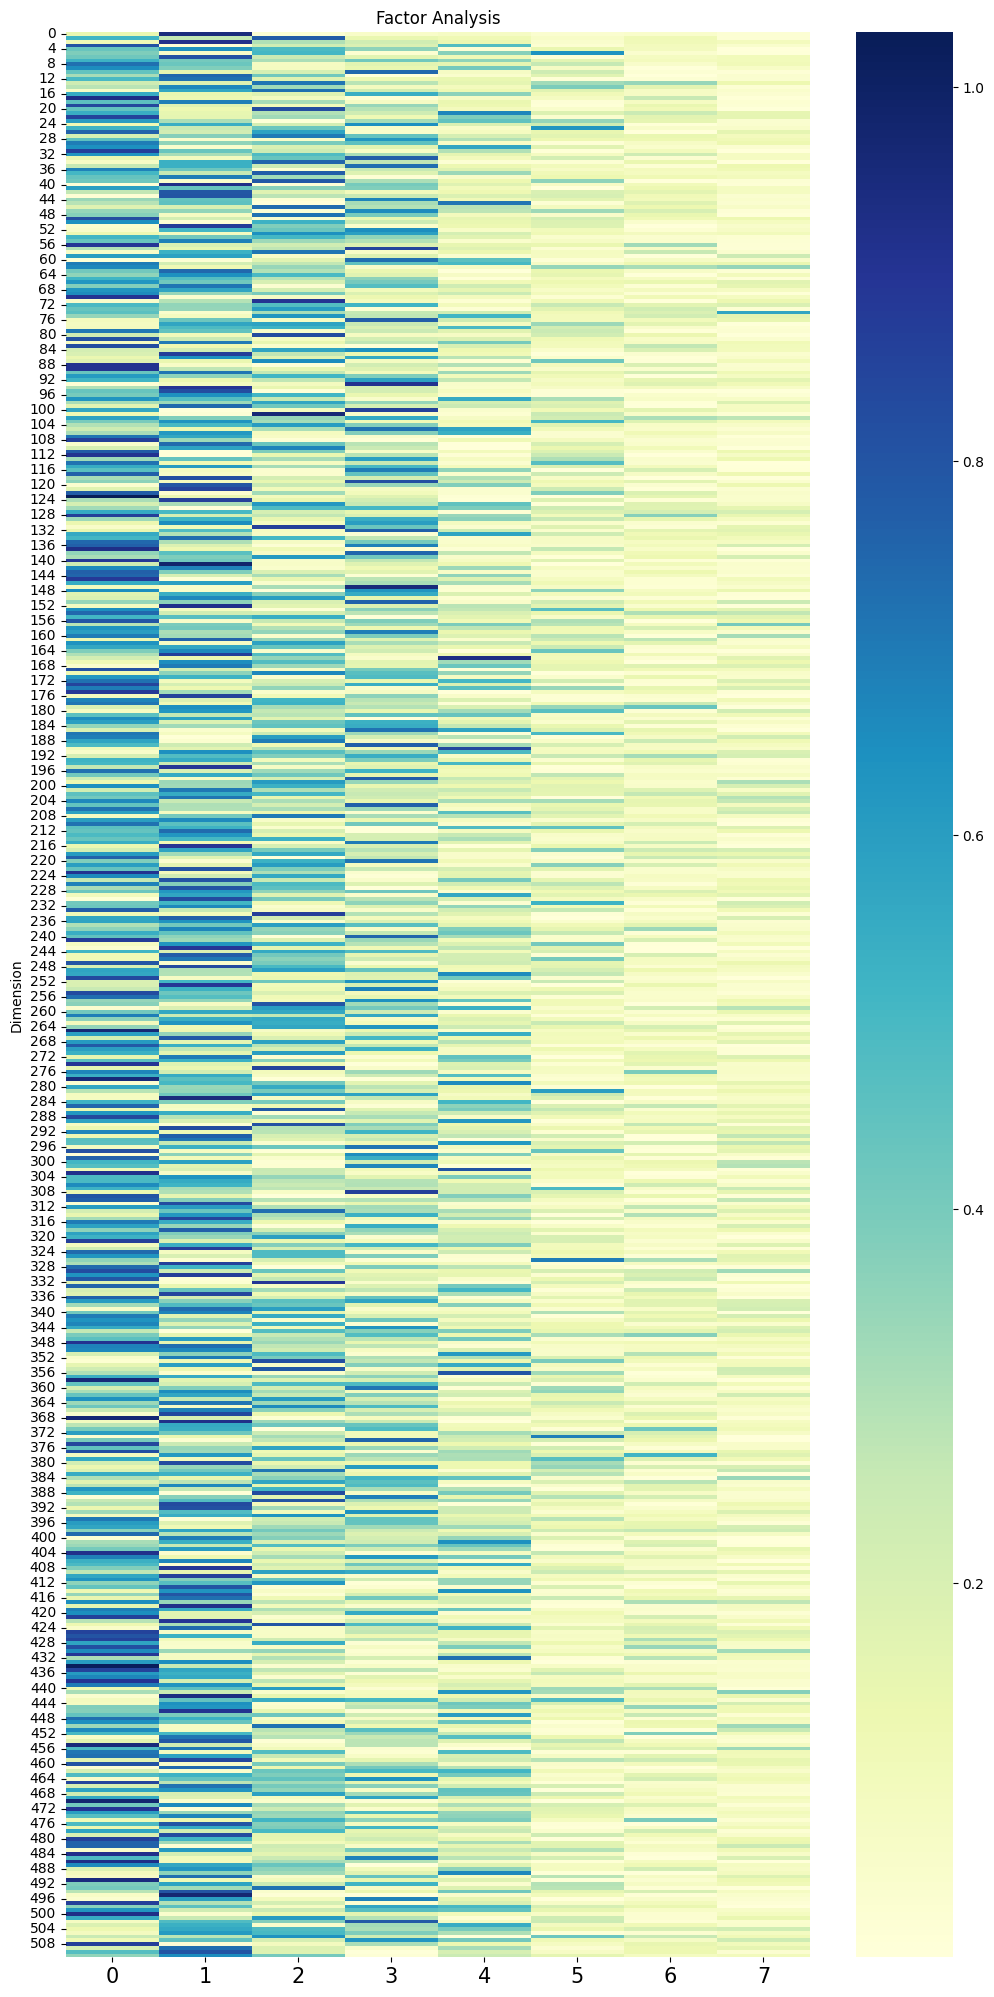

In [47]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12,25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws


# dict_={'orientation':'vertical',"label":"color  \
# scale","drawedges":True,"ticklocation":"top","extend":"min", \
# "filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_}
# cbar_kws = dict_

# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Dimension")
# plt.savefig(file_path + 'cola_dimension.png')

In [48]:
plt.savefig(file_path + 'cola_dimension.png')

<Figure size 640x480 with 0 Axes>

# 因子分析(min_count=1)

In [26]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


KMO值为:  0.9990945234873921


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


******因子分析******


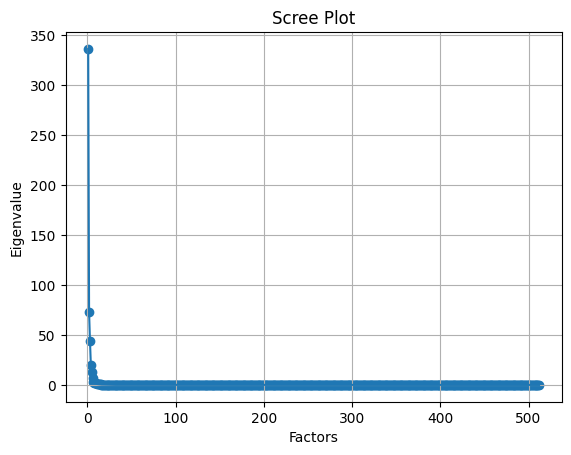

In [27]:
print('******因子分析******')
fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

# 可视化, plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

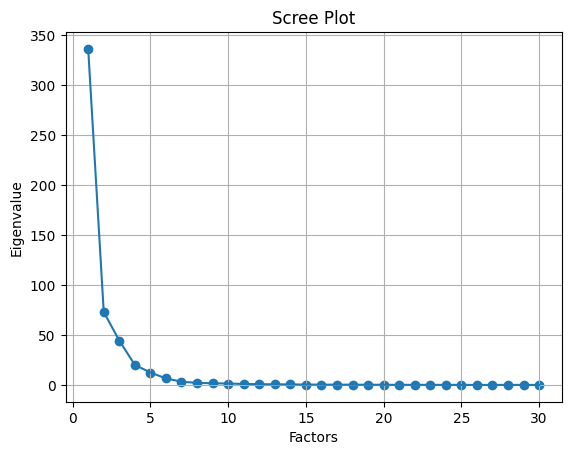

In [28]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [29]:
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)

# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "colaFA.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

(512, 8)


/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if (await self.run_code(code, result,  async_=asy)):


Text(120.72222222222221, 0.5, 'Dimension')

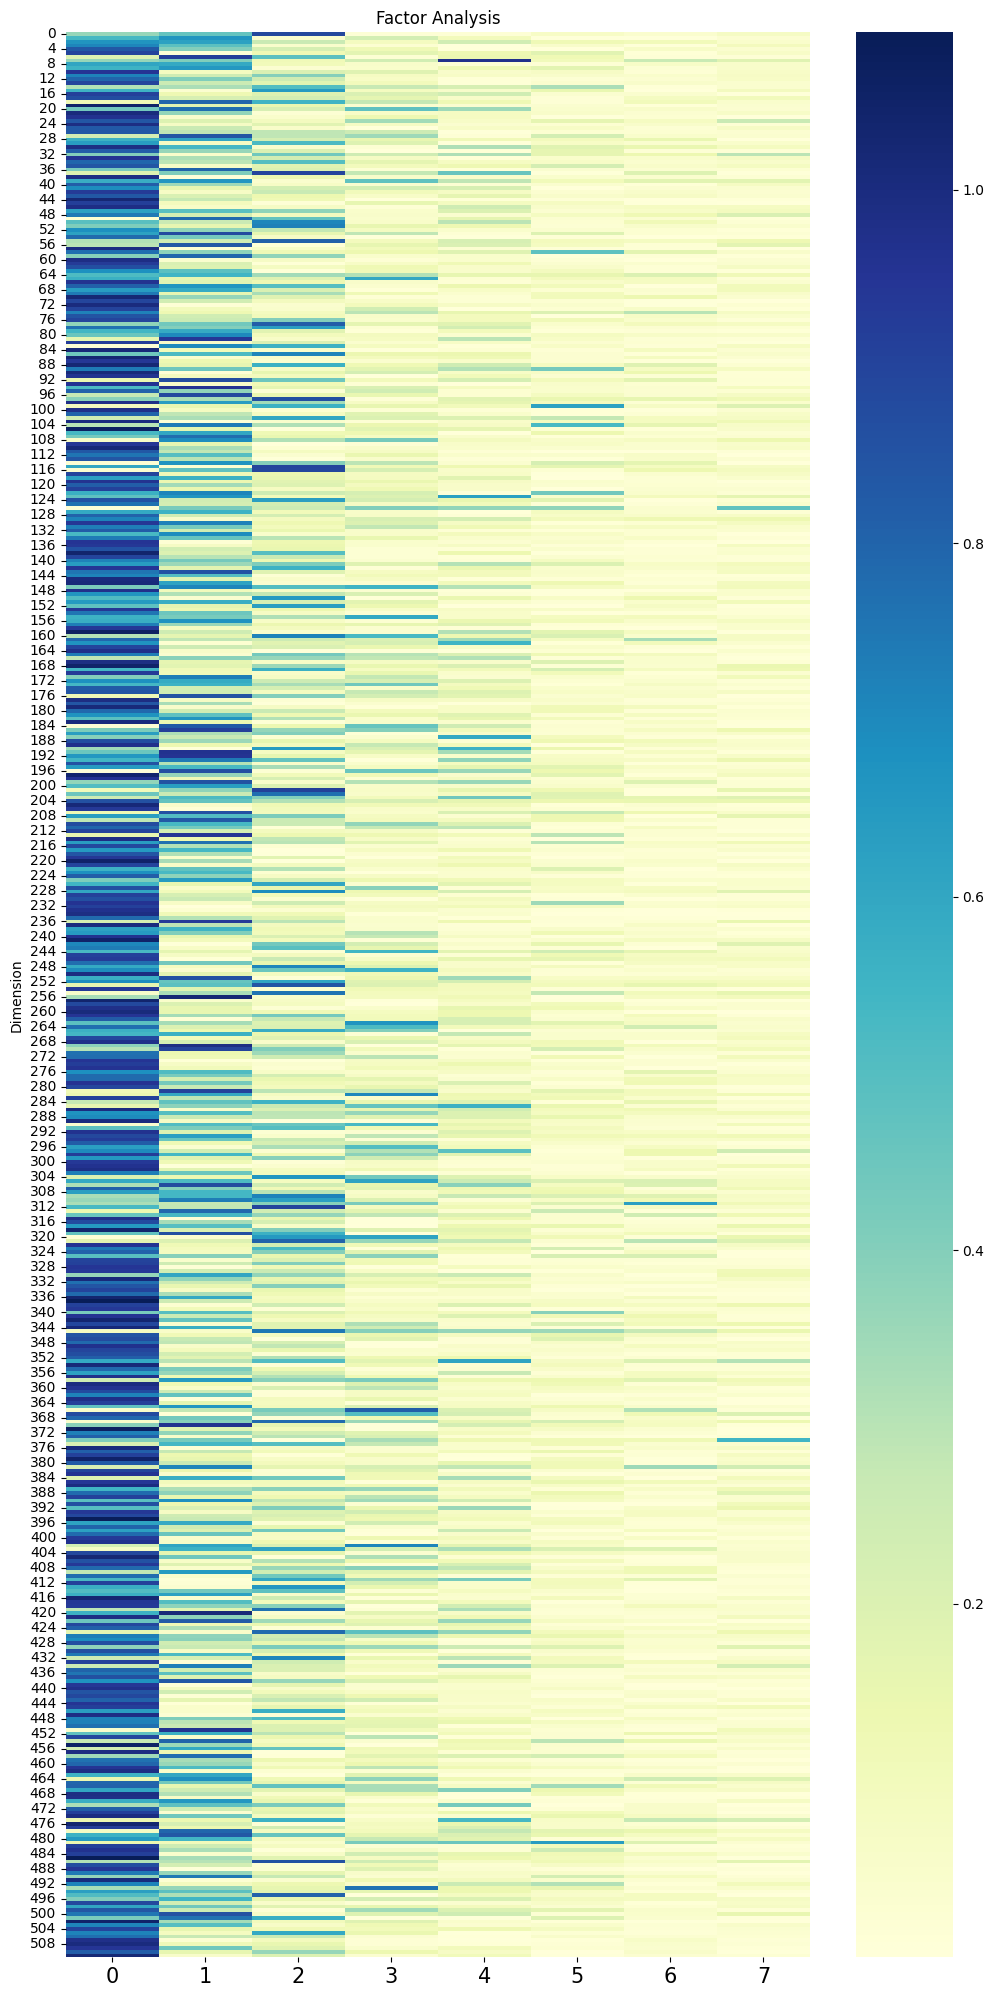

In [30]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12,25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws


# dict_={'orientation':'vertical',"label":"color  \
# scale","drawedges":True,"ticklocation":"top","extend":"min", \
# "filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_}
# cbar_kws = dict_

# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Dimension")
# plt.savefig(file_path + 'cola_dimension.png')

In [31]:
plt.savefig(file_path + 'cola_dimension_mc1.png')

<Figure size 640x480 with 0 Axes>

# 修改的模型架构

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

In [2]:
class FamAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""
    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FamAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [3]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FamAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [4]:
class FamEncoder(d2l.Encoder):
    """采用BERT编码器结构"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout,
                 use_bias=False, **kwargs):
        super(FamEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.output = nn.Linear(num_hiddens, 2)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

# 常规模型架构

In [19]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, 2)
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                d2l.EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于分类
        return self.Dense(self.outhidden(X[:, 0, :]))

In [20]:
# num_hiddens, num_layers, dropout = 512, 2, 0.1
# lr, num_epochs, device = 5e-5, 30, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8
key_size, query_size, value_size = 512, 512, 512
norm_shape = [512]

In [21]:
basenet = TransformerEncoder(
    len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

total_params = sum(p.numel() for p in basenet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in basenet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

6,463,490 total parameters.
6,463,490 training parameters.


# 加载数据集

In [5]:
from datasets import load_dataset
from transformers import BertTokenizer

dataset = load_dataset('glue', name='cola')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
class ColaDataset(torch.utils.data.Dataset):
    """用于加载cola数据集"""

    def __init__(self, dataset, num_steps, tokenizer, vocab=None):
        self.num_steps = num_steps
        self.tokens = [tokenizer.tokenize(sen) for sen in dataset['sentence']]
        maxlen = max([len(tokens) for tokens in self.tokens])
        print(f'Max length of token sequence: {maxlen}')
        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(self.tokens,
                                   reserved_tokens=['<pad>', '<cls>'])
        else:
            self.vocab = vocab
        out = list(map(self._preprocess, self.tokens))
        all_token_ids = [token_ids for token_ids, _ in out]
        all_valid_lens = [valid_lens for _, valid_lens in out]
        self.all_token_ids = torch.tensor(all_token_ids, dtype=torch.long)
        self.all_valid_lens = torch.tensor(all_valid_lens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, tokens):
        self._truncate_tokens(tokens)
        tokens = ['<cls>'] + tokens
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.num_steps - len(tokens))
        valid_lens = len(tokens)
        return token_ids, valid_lens

    def _truncate_tokens(self, tokens):
        # 为"<cls>标签预留位置"
        while len(tokens) > self.num_steps - 1:
            tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx],
                self.all_valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [7]:
num_steps, batch_size = 50, 16
train_set = ColaDataset(dataset['train'], num_steps, tokenizer)
vocab = train_set.vocab
print(f'词表大小: {len(vocab)}')  # 不区分大小写，词表大小为1881；区分大小写为2003
# test_set = ColaDataset(dataset['test'], 50, tokenizer, vocab)
valid_set = ColaDataset(dataset['validation'], 50, tokenizer, vocab)

Max length of token sequence: 45
read 8551 examples
词表大小: 5956
Max length of token sequence: 34
read 1043 examples


In [35]:
words = []
for id in train_set.all_token_ids[1].numpy().tolist():
    if id != 1:
        words.append(vocab.idx_to_token[id])
    else:
        break
print(words)

['<cls>', 'One', 'more', 'pseudo', 'general', '##ization', 'and', 'I', "'", 'm', 'giving', 'up', '.']


In [33]:
dataset['train'][1]

{'sentence': "One more pseudo generalization and I'm giving up.",
 'label': 1,
 'idx': 1}

In [8]:
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
# test_iter = torch.utils.data.DataLoader(test_set, batch_size)
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size)
print(f'训练集长度: {len(train_iter)}, '
      f'验证集长度: {len(valid_iter)}')

for (X, valid_len), y in train_iter:
    print(f'X: {X.shape}, 有效长度: {valid_len.shape}, y: {y.shape}')
    break

训练集长度: 535, 验证集长度: 66
X: torch.Size([16, 50]), 有效长度: torch.Size([16]), y: torch.Size([16])


In [12]:
X, valid_len, y

(tensor([[   2, 1032, 1447,  ...,    1,    1,    1],
         [   2,   25,   79,  ...,    1,    1,    1],
         [   2,    7,   89,  ...,    1,    1,    1],
         ...,
         [   2, 1770,    8,  ...,    1,    1,    1],
         [   2,    6, 1544,  ...,    1,    1,    1],
         [   2,  265,   46,  ...,    1,    1,    1]]),
 tensor([ 6,  7,  7, 18,  7,  8,  9, 12, 11, 16, 10,  4, 10,  7,  7, 10, 11,  7,
         14, 12, 13, 12, 12, 17, 13, 11, 13,  8,  8, 12, 10, 12]),
 tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
         0, 1, 1, 1, 0, 1, 1, 1]))

# 训练准备

In [9]:
# 参数和超参数
num_hiddens, num_layers, dropout = 512, 1, 0.1
ffn_num_input, ffn_num_hiddens, norm_shape = 512, 2048, [512]
lr, num_epochs, device = 5e-3, 10, d2l.try_gpu()

In [10]:
file_path = 'autodl-tmp/'
excelfile = pd.read_excel(file_path + 'colaFA.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [ ]:
dim_dict

In [11]:
# 实例化模型
net = FamEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, dim_dict, num_layers, dropout)
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

5,866,760 total parameters.
5,866,760 trainable parameters.


In [14]:
from torchinfo import summary

summary(net)

Layer (type:depth-idx)                        Param #
FamEncoder                                    --
├─Embedding: 1-1                              (3,049,472)
├─PositionalEncoding: 1-2                     --
│    └─Dropout: 2-1                           --
├─Sequential: 1-3                             --
│    └─EncoderBlock: 2-2                      --
│    │    └─FamAttention: 3-1                 451,846
│    │    └─AddNorm: 3-2                      1,024
│    │    └─PositionWiseFFN: 3-3              2,099,712
│    │    └─AddNorm: 3-4                      1,024
├─Sequential: 1-4                             --
│    └─Linear: 2-3                            262,656
│    └─ReLU: 2-4                              --
├─Linear: 1-5                                 1,026
Total params: 5,866,760
Trainable params: 2,817,288
Non-trainable params: 3,049,472

In [12]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


# init_embedding_weights(net.embedding, weights)
word2vecmodel = word2vec.Word2Vec.load(file_path + 'cola_word_vec_sg_min1.bin')
# weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
# init_embedding_weights(net, get_embedding_weights(
#                     vocab, word2vecmodel, num_hiddens))

In [13]:
net.embedding.weight.data.copy_(get_embedding_weights(vocab, word2vecmodel, num_hiddens))
net.embedding.weight.requires_grad = False

In [15]:
# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

FamEncoder(
  (embedding): Embedding(5956, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): FamAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=False)
        (Wq0): Linear(in_features=206, out_features=206, bias=False)
        (Wq1): Linear(in_features=90, out_features=90, bias=False)
        (Wq2): Linear(in_features=94, out_features=94, bias=False)
        (Wq3): Linear(in_features=46, out_features=46, bias=False)
        (Wq4): Linear(in_features=33, out_features=33, bias=False)
        (Wq5): Linear(in_features=19, out_features=19, bias=False)
        (Wq6): Linear(in_features=14, out_features=14, bias=False)
        (Wq7): Linear(in_features=10, out_features=10, bias=False)
        (Wk0): Linear(in_features=206, out_features=206, bias=False)
        

In [16]:
# 评估模型在验证集上准确率的函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for (X, valid_len), y in data_iter:
            X, valid_len, y = [x.to(device) for x in (X, valid_len, y)]
            metric.add(d2l.accuracy(net(X, valid_len), y), d2l.size(y))
    return metric[0] / metric[1]

In [30]:
for (X, valid_len), y in train_iter:
    print(net(X, valid_len).shape)
    break

torch.Size([32, 2])


# 正式训练1 (词表不包含频数5一下单词)

In [ ]:
# 2层注意力块

  在模型的信息汇聚层，当把线性层的输出维度减半时，即输入维度为隐藏层维度，输出维度是隐藏层维度//2，模型的收敛效果不好，训练损失、训练集准确率、验证集准确率稳定不动。

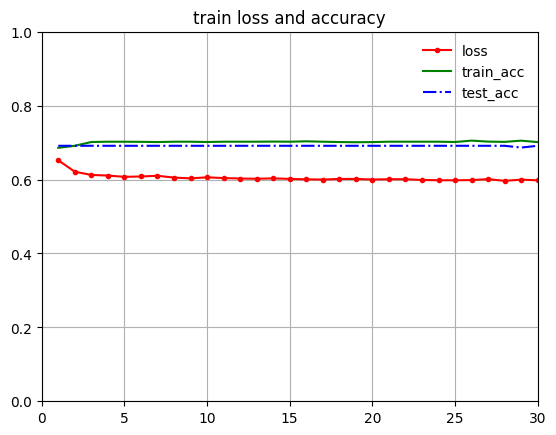

In [18]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, valid_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [46]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU(), 30 epochs
# 6,218,906 total parameters.
# num_epochs = 10
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
# trainer = torch.optim.Adam(
#     [{'params': net.embedding.parameters()},
#     {'params': forward_params,
#     'lr': lr * 10}], lr=lr)
trainer = torch.optim.SGD(forward_params, lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, valid_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(tokens, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochvalid = evaluate_accuracy_gpu(net, valid_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, '
          f'train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    valid_accuracy.append(epochvalid)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f} '
      f'验证集准确率:{valid_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 268/268 [00:14<00:00, 18.42it/s]


epoch 1, loss 0.721, train_acc 0.698, valid_acc 0.691, taking 15 seconds


100%|██████████| 268/268 [00:14<00:00, 18.18it/s]


epoch 2, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 15 seconds


100%|██████████| 268/268 [00:14<00:00, 18.74it/s]


epoch 3, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 15 seconds


100%|██████████| 268/268 [00:14<00:00, 19.06it/s]


epoch 4, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 15 seconds


100%|██████████| 268/268 [00:14<00:00, 19.00it/s]


epoch 5, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 15 seconds


100%|██████████| 268/268 [00:14<00:00, 17.90it/s]


epoch 6, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 16.82it/s]


epoch 7, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 17 seconds


100%|██████████| 268/268 [00:15<00:00, 16.99it/s]


epoch 8, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 16.99it/s]


epoch 9, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.21it/s]


epoch 10, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 16.95it/s]


epoch 11, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 17 seconds


100%|██████████| 268/268 [00:15<00:00, 17.23it/s]


epoch 12, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.09it/s]


epoch 13, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.17it/s]


epoch 14, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.23it/s]


epoch 15, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 16.98it/s]


epoch 16, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.03it/s]


epoch 17, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.05it/s]


epoch 18, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 16.93it/s]


epoch 19, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 17 seconds


100%|██████████| 268/268 [00:15<00:00, 17.47it/s]


epoch 20, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.11it/s]


epoch 21, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.43it/s]


epoch 22, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.36it/s]


epoch 23, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.12it/s]


epoch 24, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.21it/s]


epoch 25, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.37it/s]


epoch 26, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.31it/s]


epoch 27, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.21it/s]


epoch 28, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.28it/s]


epoch 29, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds


100%|██████████| 268/268 [00:15<00:00, 17.32it/s]


epoch 30, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 16 seconds
Training is finished.
训练损失:0.606, 训练集准确率:0.702 验证集准确率:0.691
在设备cuda:0上训练30周期 耗时482 秒


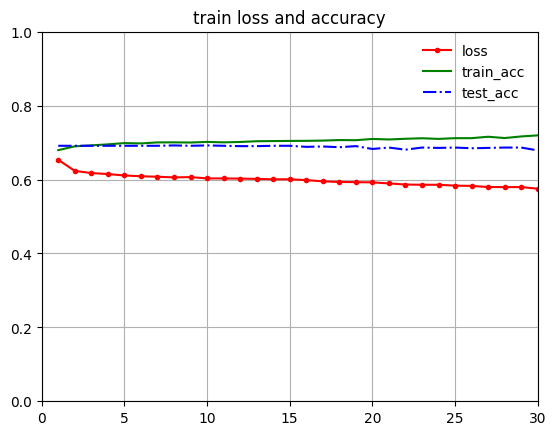

In [40]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, valid_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [18]:
torch.cuda.empty_cache()
# torch.cuda.memory_summary()
# !nvidia-smi

# 正式训练2 (包含所有词元)

In [ ]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU(), 30 epochs
# 8,241,818 total parameters.
# num_epochs = 10
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, valid_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(tokens, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochvalid = evaluate_accuracy_gpu(net, valid_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, '
          f'train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    valid_accuracy.append(epochvalid)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f} '
      f'验证集准确率:{valid_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

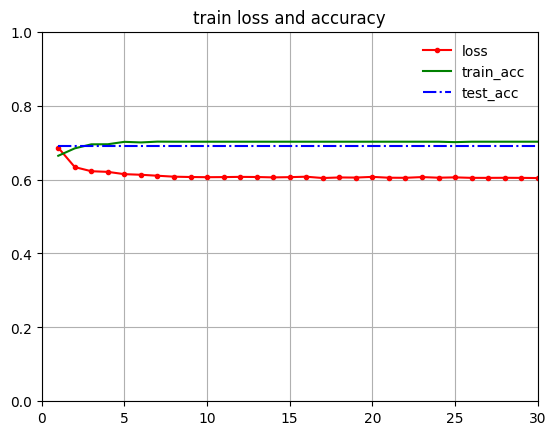

In [45]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, valid_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [17]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU(), 30 epochs
# 8,241,818 total parameters.
lr = 5e-5
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.SGD(forward_params, lr=lr)
# trainer = torch.optim.Adam(
#     [{'params': net.embedding.parameters()},
#     {'params': forward_params,
#     'lr': lr * 10}], lr=lr)

net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, valid_accuracy = [], [], []
total_start = time.time()

train_loss, train_acc = 0, 0
start_time = time.perf_counter()
for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
    (tokens, valid_len), y = data
    tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
    y = y.to(device)
    l = loss(net(tokens, valid_len), y)
    trainer.zero_grad()
    l.sum().backward()
    trainer.step()
    train_loss += l.sum().cpu().detach().numpy() / batch_size
    train_acc += d2l.accuracy(net(tokens, valid_len), y) / batch_size
    if (index + 1) % 10 == 0:
        epochloss, epochtrain = train_loss / 10, train_acc / 10
        epochvalid = evaluate_accuracy_gpu(net, valid_iter, device)
        print(f'loss {epochloss:.3f}, train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}')
        losses.append(epochloss)
        train_accuracy.append(epochtrain)
        valid_accuracy.append(epochvalid)
        train_loss, train_acc = 0, 0
# epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
# epochvalid = evaluate_accuracy_gpu(net, valid_iter, device)
# end_time = time.perf_counter()
# print(f'epoch {epoch + 1}, loss {epochloss:.3f}, '
#       f'train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}, '
#       f'taking {round(end_time - start_time)} seconds')
# losses.append(epochloss)
# train_accuracy.append(epochtrain)
# valid_accuracy.append(epochvalid)

total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f} '
      f'验证集准确率:{valid_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

  2%|▏         | 11/535 [00:02<03:27,  2.52it/s]

loss 0.791, train_acc 0.588, valid_acc 0.691


  4%|▍         | 22/535 [00:05<02:29,  3.43it/s]

loss 0.608, train_acc 0.725, valid_acc 0.691


  6%|▌         | 30/535 [00:07<02:51,  2.94it/s]

loss 0.623, train_acc 0.706, valid_acc 0.691


  8%|▊         | 42/535 [00:09<02:04,  3.95it/s]

loss 0.601, train_acc 0.719, valid_acc 0.691


 10%|▉         | 52/535 [00:11<02:14,  3.59it/s]

loss 0.617, train_acc 0.713, valid_acc 0.691


 12%|█▏        | 62/535 [00:14<02:05,  3.77it/s]

loss 0.621, train_acc 0.700, valid_acc 0.691


 13%|█▎        | 71/535 [00:16<02:30,  3.09it/s]

loss 0.695, train_acc 0.694, valid_acc 0.691


 15%|█▌        | 81/535 [00:18<02:54,  2.60it/s]

loss 0.575, train_acc 0.750, valid_acc 0.691


 17%|█▋        | 92/535 [00:21<02:17,  3.22it/s]

loss 0.598, train_acc 0.725, valid_acc 0.691


 19%|█▉        | 102/535 [00:24<02:10,  3.31it/s]

loss 0.665, train_acc 0.662, valid_acc 0.691


 21%|██        | 111/535 [00:26<02:32,  2.79it/s]

loss 0.625, train_acc 0.700, valid_acc 0.691


 23%|██▎       | 122/535 [00:28<01:59,  3.46it/s]

loss 0.588, train_acc 0.738, valid_acc 0.691


 25%|██▍       | 132/535 [00:31<01:59,  3.38it/s]

loss 0.680, train_acc 0.600, valid_acc 0.691


 27%|██▋       | 142/535 [00:34<01:54,  3.42it/s]

loss 0.572, train_acc 0.756, valid_acc 0.691


 29%|██▊       | 153/535 [00:36<01:35,  4.00it/s]

loss 0.585, train_acc 0.738, valid_acc 0.691


 30%|███       | 162/535 [00:38<01:41,  3.67it/s]

loss 0.609, train_acc 0.725, valid_acc 0.691


 32%|███▏      | 172/535 [00:41<01:45,  3.46it/s]

loss 0.593, train_acc 0.731, valid_acc 0.691


 34%|███▍      | 182/535 [00:43<01:41,  3.48it/s]

loss 0.633, train_acc 0.713, valid_acc 0.691


 36%|███▌      | 192/535 [00:45<01:30,  3.81it/s]

loss 0.620, train_acc 0.706, valid_acc 0.691


 38%|███▊      | 203/535 [00:48<01:24,  3.93it/s]

loss 0.643, train_acc 0.688, valid_acc 0.691


 39%|███▉      | 211/535 [00:50<01:58,  2.74it/s]

loss 0.625, train_acc 0.700, valid_acc 0.691


 41%|████▏     | 221/535 [00:52<02:00,  2.60it/s]

loss 0.586, train_acc 0.750, valid_acc 0.691


 43%|████▎     | 231/535 [00:55<02:01,  2.50it/s]

loss 0.666, train_acc 0.644, valid_acc 0.691


 45%|████▌     | 241/535 [00:57<01:39,  2.97it/s]

loss 0.618, train_acc 0.706, valid_acc 0.691


 47%|████▋     | 252/535 [01:00<01:18,  3.62it/s]

loss 0.596, train_acc 0.725, valid_acc 0.691


 49%|████▉     | 262/535 [01:02<01:18,  3.50it/s]

loss 0.535, train_acc 0.781, valid_acc 0.691


 51%|█████     | 272/535 [01:04<01:14,  3.51it/s]

loss 0.625, train_acc 0.700, valid_acc 0.691


 53%|█████▎    | 282/535 [01:07<01:17,  3.28it/s]

loss 0.654, train_acc 0.662, valid_acc 0.691


 55%|█████▍    | 292/535 [01:09<01:09,  3.49it/s]

loss 0.623, train_acc 0.694, valid_acc 0.691


 57%|█████▋    | 303/535 [01:12<01:00,  3.84it/s]

loss 0.642, train_acc 0.706, valid_acc 0.691


 59%|█████▊    | 314/535 [01:14<00:49,  4.44it/s]

loss 0.607, train_acc 0.719, valid_acc 0.691


 60%|██████    | 321/535 [01:16<01:04,  3.30it/s]

loss 0.596, train_acc 0.725, valid_acc 0.691


 62%|██████▏   | 331/535 [01:18<01:13,  2.78it/s]

loss 0.615, train_acc 0.700, valid_acc 0.691


 64%|██████▍   | 344/535 [01:21<00:42,  4.48it/s]

loss 0.571, train_acc 0.762, valid_acc 0.691


 66%|██████▌   | 352/535 [01:23<00:51,  3.53it/s]

loss 0.517, train_acc 0.794, valid_acc 0.691


 68%|██████▊   | 362/535 [01:25<00:48,  3.60it/s]

loss 0.646, train_acc 0.669, valid_acc 0.691


 70%|██████▉   | 373/535 [01:28<00:38,  4.19it/s]

loss 0.582, train_acc 0.738, valid_acc 0.691


 72%|███████▏  | 383/535 [01:30<00:38,  3.98it/s]

loss 0.599, train_acc 0.719, valid_acc 0.691


 73%|███████▎  | 391/535 [01:32<00:52,  2.75it/s]

loss 0.629, train_acc 0.688, valid_acc 0.691


 75%|███████▌  | 403/535 [01:34<00:36,  3.65it/s]

loss 0.627, train_acc 0.688, valid_acc 0.691


 77%|███████▋  | 413/535 [01:37<00:31,  3.92it/s]

loss 0.661, train_acc 0.644, valid_acc 0.691


 79%|███████▉  | 422/535 [01:39<00:30,  3.77it/s]

loss 0.623, train_acc 0.694, valid_acc 0.691


 81%|████████  | 432/535 [01:41<00:29,  3.49it/s]

loss 0.667, train_acc 0.656, valid_acc 0.691


 83%|████████▎ | 442/535 [01:43<00:24,  3.85it/s]

loss 0.575, train_acc 0.744, valid_acc 0.691


 85%|████████▍ | 453/535 [01:46<00:20,  3.97it/s]

loss 0.673, train_acc 0.669, valid_acc 0.691


 86%|████████▌ | 461/535 [01:48<00:29,  2.55it/s]

loss 0.569, train_acc 0.756, valid_acc 0.691


 88%|████████▊ | 472/535 [01:50<00:18,  3.43it/s]

loss 0.600, train_acc 0.719, valid_acc 0.691


 90%|█████████ | 482/535 [01:53<00:15,  3.46it/s]

loss 0.606, train_acc 0.713, valid_acc 0.691


 92%|█████████▏| 492/535 [01:55<00:13,  3.26it/s]

loss 0.661, train_acc 0.650, valid_acc 0.691


 94%|█████████▍| 502/535 [01:58<00:09,  3.52it/s]

loss 0.668, train_acc 0.662, valid_acc 0.591


 96%|█████████▌| 511/535 [02:00<00:07,  3.06it/s]

loss 0.630, train_acc 0.688, valid_acc 0.691


 98%|█████████▊| 522/535 [02:03<00:03,  3.35it/s]

loss 0.657, train_acc 0.644, valid_acc 0.691


100%|█████████▉| 533/535 [02:05<00:00,  3.72it/s]

loss 0.649, train_acc 0.650, valid_acc 0.691


100%|██████████| 535/535 [02:05<00:00,  4.25it/s]

Training is finished.
训练损失:0.649, 训练集准确率:0.650 验证集准确率:0.691
在设备cuda:0上训练10周期 耗时126 秒


# 对比训练(2层注意力块)

In [22]:
basenet.embedding.weight.data.copy_(get_embedding_weights(vocab, word2vecmodel, num_hiddens))
basenet.embedding.weight.requires_grad = False

In [24]:
summary(basenet)

Layer (type:depth-idx)                        Param #
TransformerEncoder                            --
├─Embedding: 1-1                              (3,049,472)
├─PositionalEncoding: 1-2                     --
│    └─Dropout: 2-1                           --
├─Sequential: 1-3                             --
│    └─EncoderBlock: 2-2                      --
│    │    └─MultiHeadAttention: 3-1           1,048,576
│    │    └─AddNorm: 3-2                      1,024
│    │    └─PositionWiseFFN: 3-3              2,099,712
│    │    └─AddNorm: 3-4                      1,024
├─Sequential: 1-4                             --
│    └─Linear: 2-3                            262,656
│    └─ReLU: 2-4                              --
├─Linear: 1-5                                 1,026
Total params: 6,463,490
Trainable params: 3,414,018
Non-trainable params: 3,049,472

In [25]:
# init_embedding_weights(basenet.embedding,
#                        get_embedding_weights(vocab, model, num_hiddens))

basenet.apply(xavier_init_weights)

TransformerEncoder(
  (embedding): Embedding(5956, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNor

In [57]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU(), 30 epochs
# 9,613,826 total parameters.
# num_epochs = 10
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': basenet.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, valid_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(basenet(tokens, valid_len), y) / batch_size
    epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
    epochvalid = evaluate_accuracy_gpu(basenet, valid_iter, device)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, '
          f'train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}, '
          f'taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    valid_accuracy.append(epochvalid)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f} '
      f'验证集准确率:{valid_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

100%|██████████| 268/268 [00:03<00:00, 75.56it/s]


epoch 1, loss 0.686, train_acc 0.667, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.05it/s]


epoch 2, loss 0.632, train_acc 0.689, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 74.76it/s]


epoch 3, loss 0.619, train_acc 0.697, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 78.92it/s]


epoch 4, loss 0.613, train_acc 0.699, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.46it/s]


epoch 5, loss 0.612, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 75.36it/s]


epoch 6, loss 0.609, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 78.70it/s]


epoch 7, loss 0.609, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 77.56it/s]


epoch 8, loss 0.607, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 78.35it/s]


epoch 9, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.89it/s]


epoch 10, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.30it/s]


epoch 11, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 77.63it/s]


epoch 12, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.54it/s]


epoch 13, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 81.39it/s]


epoch 14, loss 0.607, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 79.63it/s]


epoch 15, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.98it/s]


epoch 16, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 79.27it/s]


epoch 17, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.87it/s]


epoch 18, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.68it/s]


epoch 19, loss 0.608, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 78.88it/s]


epoch 20, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 78.72it/s]


epoch 21, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.37it/s]


epoch 22, loss 0.607, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 76.74it/s]


epoch 23, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 76.49it/s]


epoch 24, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 78.46it/s]


epoch 25, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 77.01it/s]


epoch 26, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.12it/s]


epoch 27, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 75.20it/s]


epoch 28, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 4 seconds


100%|██████████| 268/268 [00:03<00:00, 79.45it/s]


epoch 29, loss 0.606, train_acc 0.702, valid_acc 0.691, taking 3 seconds


100%|██████████| 268/268 [00:03<00:00, 79.91it/s]


epoch 30, loss 0.605, train_acc 0.702, valid_acc 0.691, taking 3 seconds
Training is finished.
训练损失:0.605, 训练集准确率:0.702 验证集准确率:0.691
在设备cuda:0上训练30周期 耗时106 秒


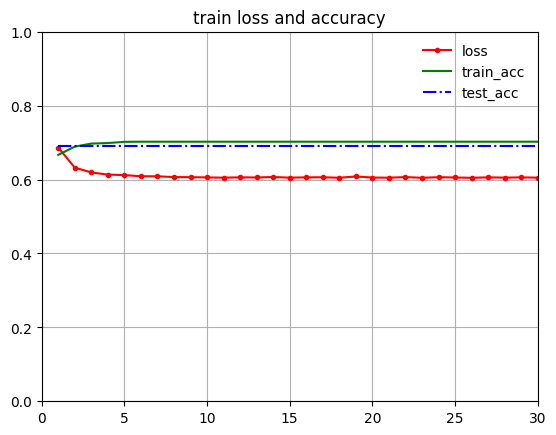

In [58]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, num_epochs, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy, validation_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-', label='train_acc')
plt.plot(epochs, valid_accuracy, 'b-.', label='test_acc')
# plt.plot(epochs, validation_accuracy, 'y-.', label='valid_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [26]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU(), 30 epochs
# 3,414,018 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.SGD(forward_params, lr=lr)
# trainer = torch.optim.Adam(
#     [{'params': basenet.embedding.parameters()},
#     {'params': forward_params,
#     'lr': lr * 10}], lr=lr)

basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, valid_accuracy = [], [], []
total_start = time.time()

train_loss, train_acc = 0, 0
start_time = time.perf_counter()
for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
    (tokens, valid_len), y = data
    tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
    y = y.to(device)
    l = loss(basenet(tokens, valid_len), y)
    trainer.zero_grad()
    l.sum().backward()
    trainer.step()
    train_loss += l.sum().cpu().detach().numpy() / batch_size
    train_acc += d2l.accuracy(basenet(tokens, valid_len), y) / batch_size
    if (index + 1) % 10 == 0:
        epochloss, epochtrain = train_loss / 10, train_acc / 10
        epochvalid = evaluate_accuracy_gpu(basenet, valid_iter, device)
        print(f'loss {epochloss:.3f}, train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}')
        losses.append(epochloss)
        train_accuracy.append(epochtrain)
        valid_accuracy.append(epochvalid)
        train_loss, train_acc = 0, 0
# epochloss, epochtrain = train_loss / num_batches, train_acc / num_batches
# epochvalid = evaluate_accuracy_gpu(basenet, valid_iter, device)
# end_time = time.perf_counter()
# print(f'epoch {epoch + 1}, loss {epochloss:.3f}, '
#       f'train_acc {epochtrain:.3f}, valid_acc {epochvalid:.3f}, '
#       f'taking {round(end_time - start_time)} seconds')
# losses.append(epochloss)
# train_accuracy.append(epochtrain)
# valid_accuracy.append(epochvalid)

total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f} '
      f'验证集准确率:{valid_accuracy[-1]:.3f}\n'
      f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} 秒')

  2%|▏         | 10/535 [00:00<00:12, 42.64it/s]

loss 0.609, train_acc 0.713, valid_acc 0.691


  4%|▎         | 20/535 [00:00<00:13, 38.67it/s]

loss 0.625, train_acc 0.700, valid_acc 0.691


  7%|▋         | 40/535 [00:00<00:10, 45.26it/s]

loss 0.540, train_acc 0.775, valid_acc 0.691
loss 0.604, train_acc 0.713, valid_acc 0.691


  9%|▉         | 50/535 [00:01<00:10, 45.99it/s]

loss 0.626, train_acc 0.700, valid_acc 0.691


 11%|█         | 60/535 [00:01<00:10, 44.69it/s]

loss 0.619, train_acc 0.706, valid_acc 0.691


 13%|█▎        | 70/535 [00:01<00:10, 44.49it/s]

loss 0.607, train_acc 0.725, valid_acc 0.691


 17%|█▋        | 90/535 [00:02<00:09, 45.86it/s]

loss 0.631, train_acc 0.688, valid_acc 0.691
loss 0.576, train_acc 0.750, valid_acc 0.691


 19%|█▊        | 100/535 [00:02<00:09, 45.77it/s]

loss 0.606, train_acc 0.713, valid_acc 0.691


 21%|██        | 110/535 [00:02<00:09, 45.57it/s]

loss 0.644, train_acc 0.662, valid_acc 0.691


 22%|██▏       | 120/535 [00:02<00:09, 45.05it/s]

loss 0.627, train_acc 0.700, valid_acc 0.691


 24%|██▍       | 130/535 [00:02<00:09, 43.30it/s]

loss 0.645, train_acc 0.681, valid_acc 0.691


 28%|██▊       | 149/535 [00:03<00:07, 49.89it/s]

loss 0.670, train_acc 0.662, valid_acc 0.691
loss 0.652, train_acc 0.656, valid_acc 0.691


 32%|███▏      | 170/535 [00:03<00:08, 40.96it/s]

loss 0.654, train_acc 0.688, valid_acc 0.691
loss 0.676, train_acc 0.613, valid_acc 0.691


 34%|███▎      | 180/535 [00:04<00:08, 44.23it/s]

loss 0.569, train_acc 0.756, valid_acc 0.691


 36%|███▌      | 190/535 [00:04<00:07, 45.81it/s]

loss 0.663, train_acc 0.644, valid_acc 0.691


 39%|███▉      | 209/535 [00:04<00:06, 47.41it/s]

loss 0.661, train_acc 0.644, valid_acc 0.691


 40%|████      | 215/535 [00:05<00:08, 37.74it/s]

loss 0.629, train_acc 0.688, valid_acc 0.691


 41%|████      | 220/535 [00:05<00:09, 32.72it/s]

loss 0.655, train_acc 0.662, valid_acc 0.691


 44%|████▍     | 238/535 [00:05<00:07, 41.16it/s]

loss 0.640, train_acc 0.662, valid_acc 0.691


 46%|████▌     | 244/535 [00:05<00:07, 37.40it/s]

loss 0.664, train_acc 0.662, valid_acc 0.691


 48%|████▊     | 259/535 [00:06<00:06, 43.02it/s]

loss 0.642, train_acc 0.675, valid_acc 0.691


 50%|████▉     | 265/535 [00:06<00:07, 34.83it/s]

loss 0.595, train_acc 0.719, valid_acc 0.691


 50%|█████     | 270/535 [00:06<00:08, 31.30it/s]

loss 0.633, train_acc 0.706, valid_acc 0.691


 52%|█████▏    | 280/535 [00:06<00:07, 32.94it/s]

loss 0.661, train_acc 0.675, valid_acc 0.691


 54%|█████▍    | 290/535 [00:07<00:06, 36.77it/s]

loss 0.541, train_acc 0.781, valid_acc 0.691


 58%|█████▊    | 310/535 [00:07<00:05, 41.66it/s]

loss 0.589, train_acc 0.731, valid_acc 0.691
loss 0.586, train_acc 0.744, valid_acc 0.691


 62%|██████▏   | 330/535 [00:08<00:04, 43.53it/s]

loss 0.571, train_acc 0.756, valid_acc 0.691
loss 0.618, train_acc 0.713, valid_acc 0.691


 64%|██████▎   | 340/535 [00:08<00:04, 44.24it/s]

loss 0.676, train_acc 0.669, valid_acc 0.691


 67%|██████▋   | 360/535 [00:08<00:03, 48.99it/s]

loss 0.599, train_acc 0.719, valid_acc 0.691
loss 0.591, train_acc 0.731, valid_acc 0.691


 69%|██████▉   | 370/535 [00:08<00:03, 45.64it/s]

loss 0.649, train_acc 0.688, valid_acc 0.691


 73%|███████▎  | 390/535 [00:09<00:03, 47.78it/s]

loss 0.657, train_acc 0.681, valid_acc 0.691
loss 0.623, train_acc 0.700, valid_acc 0.691


 76%|███████▌  | 406/535 [00:09<00:02, 52.53it/s]

loss 0.608, train_acc 0.706, valid_acc 0.691


 77%|███████▋  | 412/535 [00:09<00:02, 50.62it/s]

loss 0.632, train_acc 0.688, valid_acc 0.691


 79%|███████▊  | 420/535 [00:09<00:02, 45.22it/s]

loss 0.539, train_acc 0.775, valid_acc 0.691


 80%|████████  | 430/535 [00:10<00:02, 42.12it/s]

loss 0.603, train_acc 0.719, valid_acc 0.691


 82%|████████▏ | 440/535 [00:10<00:02, 42.91it/s]

loss 0.624, train_acc 0.700, valid_acc 0.691


 84%|████████▍ | 450/535 [00:10<00:01, 44.19it/s]

loss 0.651, train_acc 0.681, valid_acc 0.691


 86%|████████▌ | 460/535 [00:10<00:01, 40.49it/s]

loss 0.549, train_acc 0.762, valid_acc 0.691


 90%|████████▉ | 480/535 [00:11<00:01, 43.44it/s]

loss 0.591, train_acc 0.750, valid_acc 0.691
loss 0.599, train_acc 0.731, valid_acc 0.691


 93%|█████████▎| 497/535 [00:11<00:00, 48.66it/s]

loss 0.603, train_acc 0.725, valid_acc 0.691


 94%|█████████▍| 503/535 [00:11<00:00, 40.98it/s]

loss 0.605, train_acc 0.719, valid_acc 0.691


 97%|█████████▋| 517/535 [00:12<00:00, 43.60it/s]

loss 0.590, train_acc 0.744, valid_acc 0.691


 98%|█████████▊| 522/535 [00:12<00:00, 39.08it/s]

loss 0.614, train_acc 0.713, valid_acc 0.691


100%|██████████| 535/535 [00:12<00:00, 42.03it/s]

loss 0.650, train_acc 0.669, valid_acc 0.691
Training is finished.
训练损失:0.650, 训练集准确率:0.669 验证集准确率:0.691
在设备cuda:0上训练10周期 耗时13 秒
